# Imbalanced Classification

### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=9)
import missingno as mi

### Statistical Normality Tests
import scipy.stats as stat
from scipy.stats import shapiro, normaltest

import re
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Load data into dataframes

`Unzip and extract the files to a folder called data`

In [2]:
train_data = pd.read_csv('E:Datasets/census/census-income.data', delimiter=',',header = None, na_values = [' ?',' NA'])
test_data = pd.read_csv('E:Datasets/census/census-income.test', delimiter=',',header = None, na_values = [' ?',' NA'])

In [3]:
column_names = ['age','class_of_worker','industry_code','occupation_code','education','wage_per_hour',
        'enrolled_in_edu_inst_lastwk','marital_status', 'major_industry_code','major_occupation_code','race',
        'hispanic_origin','sex','member_of_labor_union','reason_for_unemployment','full_parttime_employment_stat',
        'capital_gains','capital_losses','dividend_from_Stocks','tax_filer_status','region_of_previous_residence',
        'state_of_previous_residence','d_household_family_stat','d_household_summary','instance_weight','migration_msa',
        'migration_reg','migration_within_reg','live_1_year_ago','migration_sunbelt','num_person_Worked_employer',
        'family_members_under_18','country_father','country_mother','country_self','citizenship',
        'business_or_self_employed','fill_questionnaire_veteran_admin','veterans_benefits','weeks_worked_in_year',
        'year','income_level']
train_data.columns = column_names
test_data.columns = column_names

### Exploratory Data Analysis and Visualisation

**Sample observations from the train and test datasets**

In [4]:
train_data.sample(3)

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
198871,41,Local government,43,31,High school graduate,0,Not in universe,Never married,Education,Other service,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
169460,51,Private,43,10,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Education,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,40,95,- 50000.
71590,12,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
test_data.sample(3)

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
15186,69,Not in universe,0,0,High school graduate,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,50000+.
40259,7,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
39414,38,Private,4,33,Some college but no degree,1600,Not in universe,Married-civilian spouse present,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


**Number of observations and features we have**

In [6]:
print('Train data Shape:',train_data.shape)
print('Test data Shape:',test_data.shape)

Train data Shape: (199523, 42)
Test data Shape: (99762, 42)


In [7]:
print('The Train dataset contains {} instances and {} attributes'.format(train_data.shape[0], train_data.shape[1]-1))
print('The Test dataset contains {} instances and {} attributes'.format(test_data.shape[0], test_data.shape[1]-1))

The Train dataset contains 199523 instances and 41 attributes
The Test dataset contains 99762 instances and 41 attributes


**Data types of my features? Are they numeric or Categorical?**

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
age                                 199523 non-null int64
class_of_worker                     199523 non-null object
industry_code                       199523 non-null int64
occupation_code                     199523 non-null int64
education                           199523 non-null object
wage_per_hour                       199523 non-null int64
enrolled_in_edu_inst_lastwk         199523 non-null object
marital_status                      199523 non-null object
major_industry_code                 199523 non-null object
major_occupation_code               199523 non-null object
race                                199523 non-null object
hispanic_origin                     198649 non-null object
sex                                 199523 non-null object
member_of_labor_union               199523 non-null object
reason_for_unemployment             199523 non-null object
full_par

**Check statistical information of the dataframe**

In [9]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,199523.0,34.494199,22.310895,0.00,15.000,33.00,50.00,90.0
industry_code,199523.0,15.352320,18.067129,0.00,0.000,0.00,33.00,51.0
occupation_code,199523.0,11.306556,14.454204,0.00,0.000,0.00,26.00,46.0
wage_per_hour,199523.0,55.426908,274.896454,0.00,0.000,0.00,0.00,9999.0
capital_gains,199523.0,434.718990,4697.531280,0.00,0.000,0.00,0.00,99999.0
capital_losses,199523.0,37.313788,271.896428,0.00,0.000,0.00,0.00,4608.0
dividend_from_Stocks,199523.0,197.529533,1984.163658,0.00,0.000,0.00,0.00,99999.0
instance_weight,199523.0,1740.380269,993.768156,37.87,1061.615,1618.31,2188.61,18656.3
num_person_Worked_employer,199523.0,1.956180,2.365126,0.00,0.000,1.00,4.00,6.0
business_or_self_employed,199523.0,0.175438,0.553694,0.00,0.000,0.00,0.00,2.0


In [10]:
train_data.describe(include='object').transpose()

,count,unique,top,freq
class_of_worker,199523,9,Not in universe,100245
education,199523,17,High school graduate,48407
enrolled_in_edu_inst_lastwk,199523,3,Not in universe,186943
marital_status,199523,7,Never married,86485
major_industry_code,199523,24,Not in universe or children,100684
major_occupation_code,199523,15,Not in universe,100684
race,199523,5,White,167365
hispanic_origin,198649,9,All other,171907
sex,199523,2,Female,103984
member_of_labor_union,199523,3,Not in universe,180459


**Check for number of Unique values within the each variable**

In [11]:
for column in train_data:
    print(column, train_data[column].nunique())

age 91
class_of_worker 9
industry_code 52
occupation_code 47
education 17
wage_per_hour 1240
enrolled_in_edu_inst_lastwk 3
marital_status 7
major_industry_code 24
major_occupation_code 15
race 5
hispanic_origin 9
sex 2
member_of_labor_union 3
reason_for_unemployment 6
full_parttime_employment_stat 8
capital_gains 132
capital_losses 113
dividend_from_Stocks 1478
tax_filer_status 6
region_of_previous_residence 6
state_of_previous_residence 50
d_household_family_stat 38
d_household_summary 8
instance_weight 99800
migration_msa 9
migration_reg 8
migration_within_reg 9
live_1_year_ago 3
migration_sunbelt 3
num_person_Worked_employer 7
family_members_under_18 5
country_father 42
country_mother 42
country_self 42
citizenship 5
business_or_self_employed 3
fill_questionnaire_veteran_admin 3
veterans_benefits 3
weeks_worked_in_year 53
year 2
income_level 2


**Check for Unique values within the target variable**

In [12]:
train_data.income_level.unique()

array([' - 50000.', ' 50000+.'], dtype=object)

In [13]:
test_data.income_level.unique()

array([' - 50000.', ' 50000+.'], dtype=object)

**Check severity of imbalanced classes in our Train data:** 

Calculate Frequency

 - 50000.    187141
 50000+.      12382
Name: income_level, dtype: int64


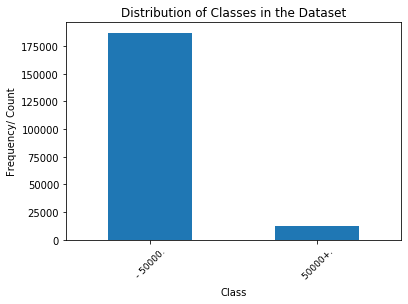

In [14]:
class_distribution = train_data['income_level'].value_counts()
print(class_distribution)
class_distribution.plot(kind='bar',)
plt.xlabel('Class')
plt.ylabel('Frequency/ Count')
plt.title('Distribution of Classes in the Dataset')
plt.xticks(rotation=45)
plt.show()

**Calculate proportion of occurance**

 - 50000.    94.0
 50000+.      6.0
Name: income_level, dtype: float64


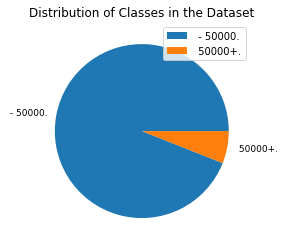

In [15]:
class_distribution_perc = round(train_data['income_level'].value_counts()/len(train_data['income_level'])*100)
print(class_distribution_perc)
class_distribution_perc.plot(kind='pie')
plt.ylabel(' ')
plt.title('Distribution of Classes in the Dataset')
plt.legend()
plt.show()

From the graphs we can see that the dataset is highly imbalanced, one of the class constistutes more than 93% of the data.

**Encode target variable to 0s and 1s**

In [16]:
income_level = {' - 50000.': 0,' 50000+.': 1}
train_data['income_level'] = train_data['income_level'].replace(income_level)
test_data['income_level'] = test_data['income_level'].replace(income_level)

#### Plot numerical variables histograms overlapped with density curves

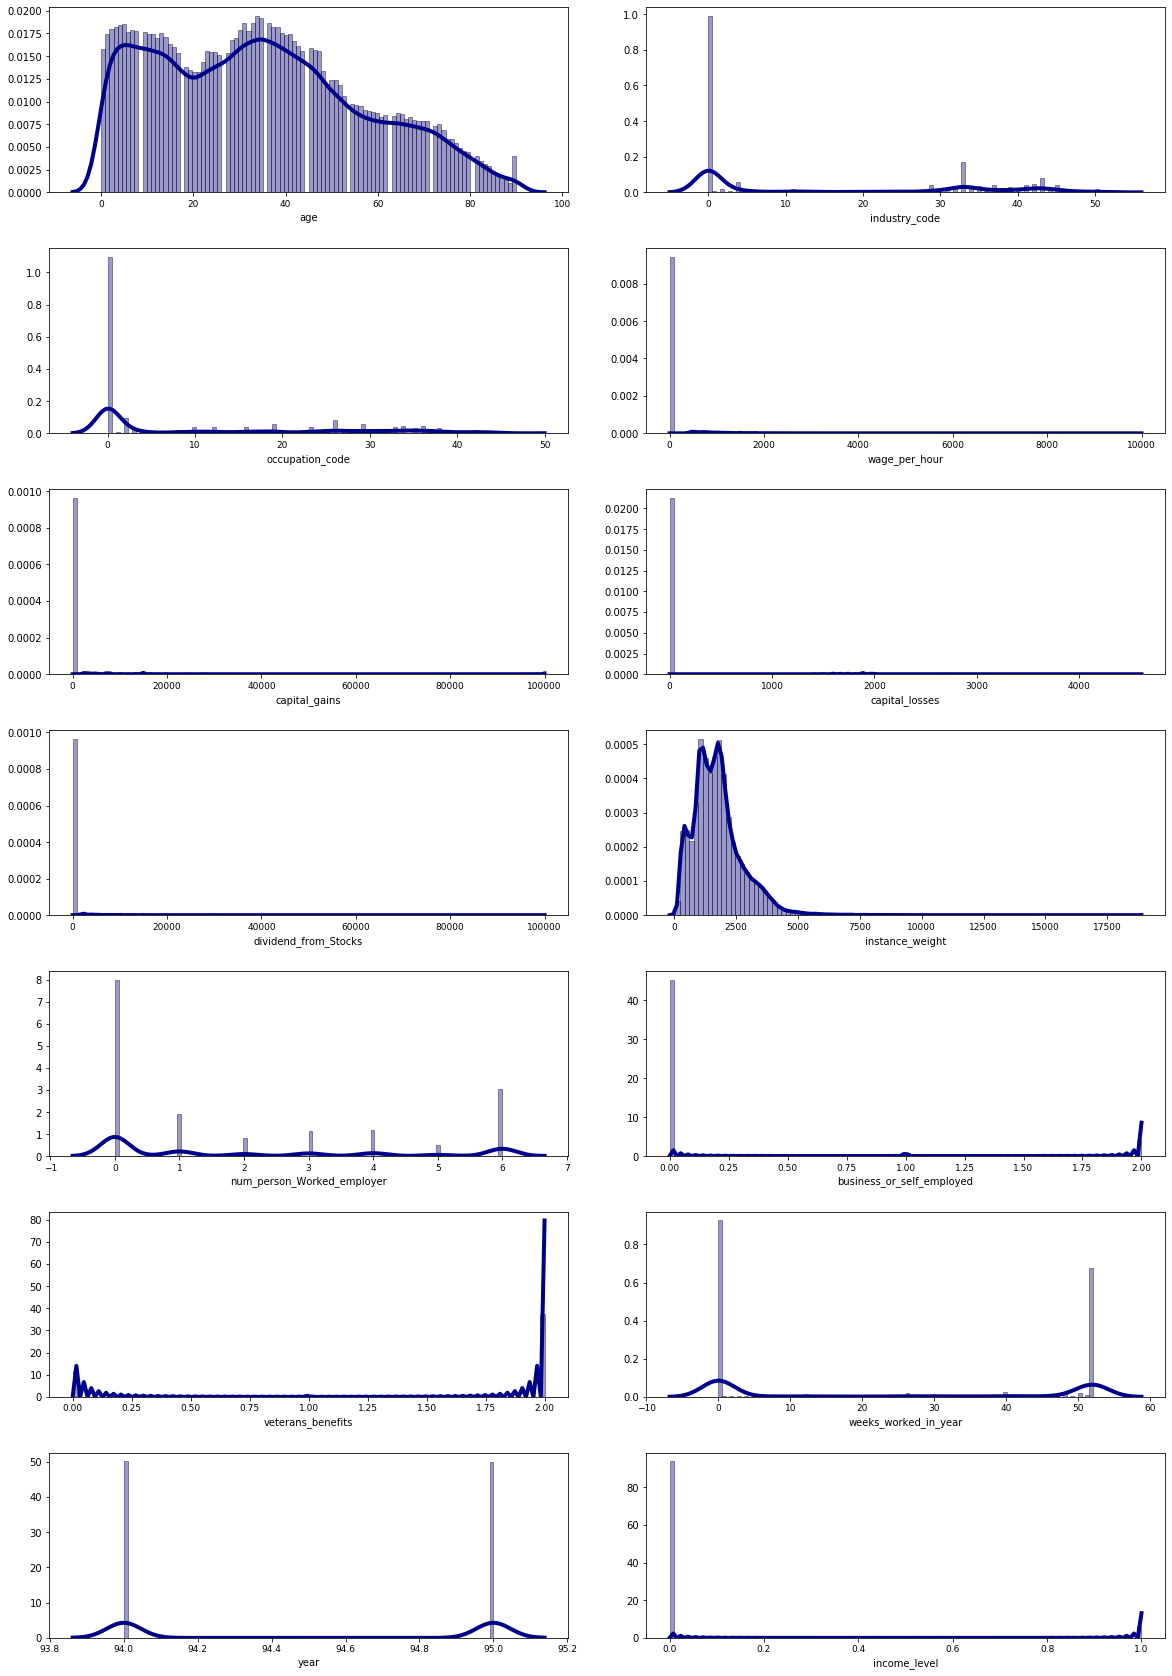

In [17]:
numeric_cols = list(train_data.select_dtypes(exclude=['object']))
fig, axs = plt.subplots(7,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.15)
axs = axs.ravel()
for x in list(numeric_cols):
    i = list(numeric_cols).index(x)
    sns.distplot(train_data[x], hist=True, kde=True, bins=int(500/5), color = 'darkblue',  
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=axs[i])
fig.show()

From the above graphs: wage_per_hour, capital_gains, capital_losses, dividend_from_Stocks distributions are right skewed.
In skewed distribution, normalizing is always an option.

**Visual Normality checks**

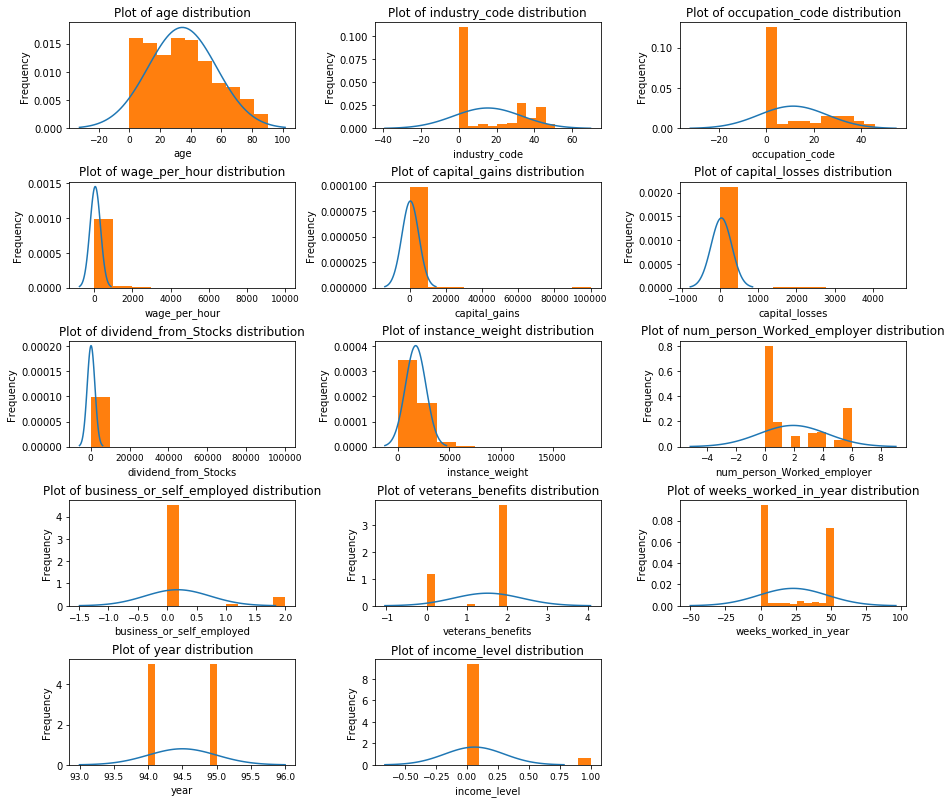

In [18]:
plt.figure(figsize=(15,40))

for i in numeric_cols:
    j = list(train_data[numeric_cols]).index(i)
    plt.subplot(len(numeric_cols),3,j+1)
    plt.subplots_adjust(hspace=.5, wspace = 0.35)
    plt.title('Plot of %s distribution' %i)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    mu = train_data[i].mean()
    sigma = train_data[i].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stat.norm.pdf(x, mu, sigma))   
    plt.hist(train_data[i],normed=True)
plt.show()

**Statistical Normality Tests – Shapiro-Wilk Test**

In [19]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

for i in numeric_cols:
    # normality test
    stat, p = shapiro(train_data[i])
    
    alpha = 0.05
    if p > alpha:
        print('{} distribution looks Gaussian with P-value:{}\n'.format(i, round(p,3)))
    else:
        print('{} distribution with P-value: {} does not look Gaussian \n'.format(i, round(p,3)))

age distribution with P-value: 0.0 does not look Gaussian 

industry_code distribution with P-value: 0.0 does not look Gaussian 

occupation_code distribution with P-value: 0.0 does not look Gaussian 

wage_per_hour distribution with P-value: 0.0 does not look Gaussian 

capital_gains distribution with P-value: 0.0 does not look Gaussian 

capital_losses distribution with P-value: 0.0 does not look Gaussian 

dividend_from_Stocks distribution with P-value: 0.0 does not look Gaussian 

instance_weight distribution with P-value: 0.0 does not look Gaussian 

num_person_Worked_employer distribution with P-value: 0.0 does not look Gaussian 

business_or_self_employed distribution with P-value: 0.0 does not look Gaussian 

veterans_benefits distribution with P-value: 0.0 does not look Gaussian 

weeks_worked_in_year distribution with P-value: 0.0 does not look Gaussian 

year distribution with P-value: 0.0 does not look Gaussian 

income_level distribution with P-value: 0.0 does not look Gau

**Statistical Normality Tests – D’Agostino’s $K^2$ Test**

In [20]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest

for i in numeric_cols:
    # normality test
    stat, p = normaltest(train_data[i])
    
    alpha = 0.05
    if p > alpha:
        print('{} distribution looks Gaussian with P-value:{}\n'.format(i, round(p,3)))
    else:
        print('{} distribution with P-value: {} does not look Gaussian \n'.format(i, round(p,3)))

age distribution with P-value: 0.0 does not look Gaussian 

industry_code distribution with P-value: 0.0 does not look Gaussian 

occupation_code distribution with P-value: 0.0 does not look Gaussian 

wage_per_hour distribution with P-value: 0.0 does not look Gaussian 

capital_gains distribution with P-value: 0.0 does not look Gaussian 

capital_losses distribution with P-value: 0.0 does not look Gaussian 

dividend_from_Stocks distribution with P-value: 0.0 does not look Gaussian 

instance_weight distribution with P-value: 0.0 does not look Gaussian 

num_person_Worked_employer distribution with P-value: 0.0 does not look Gaussian 

business_or_self_employed distribution with P-value: 0.0 does not look Gaussian 

veterans_benefits distribution with P-value: 0.0 does not look Gaussian 

weeks_worked_in_year distribution with P-value: 0.0 does not look Gaussian 

year distribution with P-value: 0.0 does not look Gaussian 

income_level distribution with P-value: 0.0 does not look Gau

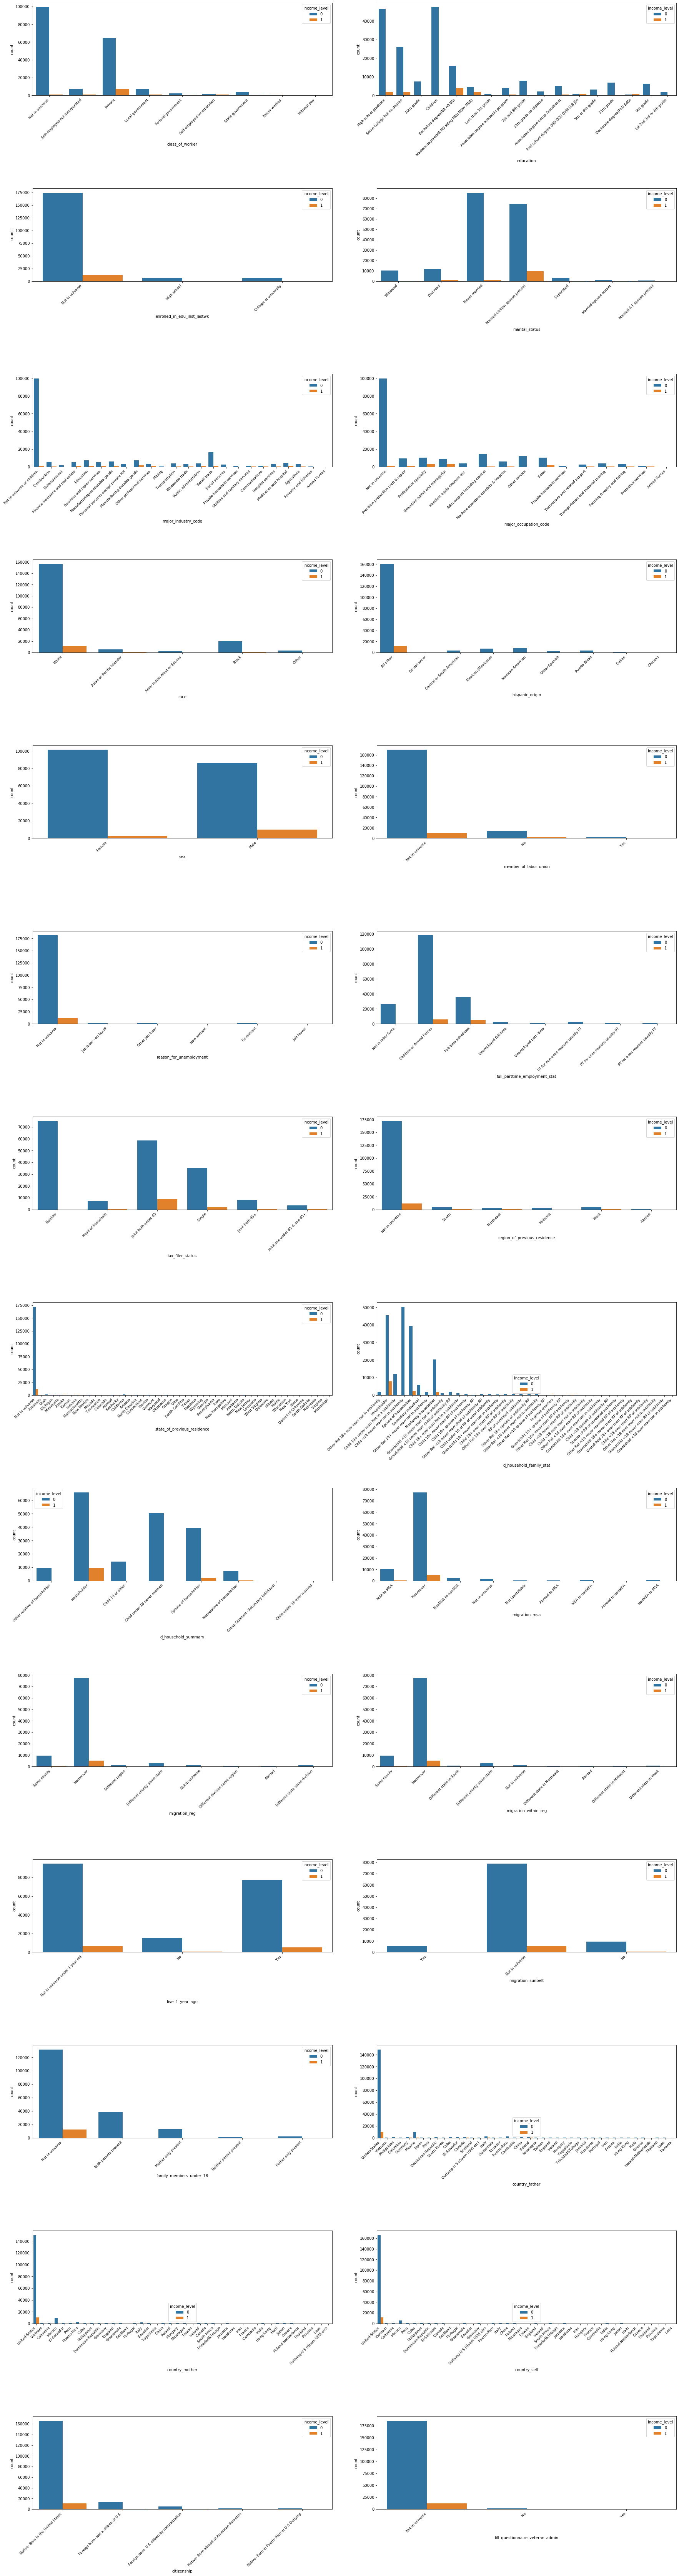

In [21]:
#Plot of Categorical Distributions (Counts of observations per category per class)
non_numeric_cols = list(train_data.select_dtypes(include=['object']))
fig, axs = plt.subplots(14,2, figsize=(30, 120), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1.0, wspace=.15)
axs = axs.ravel()
for x in list(non_numeric_cols):
    i = list(non_numeric_cols).index(x)
    chart = sns.countplot(x = x, hue= 'income_level', data=train_data, ax=axs[i])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.show()

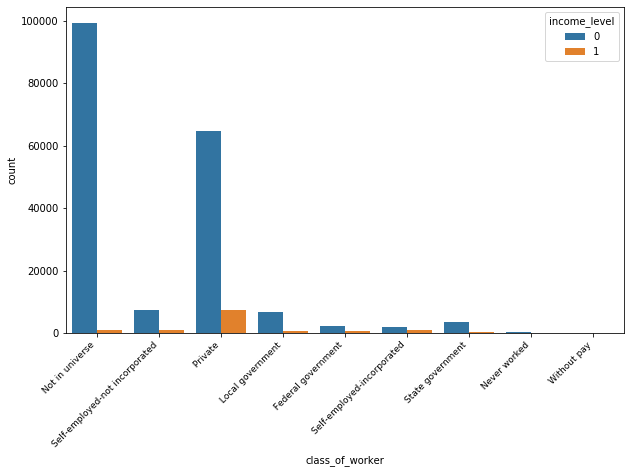

In [22]:
plt.figure(figsize=(10, 6))
chart = sns.countplot(x = 'class_of_worker', hue= 'income_level', data=train_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

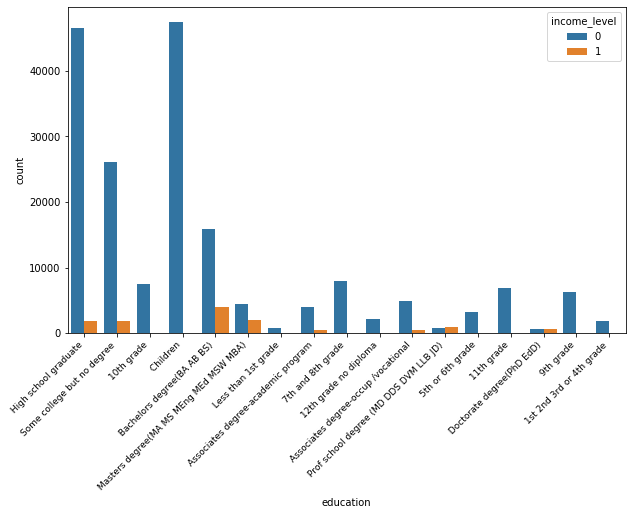

In [23]:
plt.figure(figsize=(10, 6))
chart = sns.countplot(x = 'education', hue= 'income_level', data=train_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**Feature Correlation Analysis of the numeric Variables**

To understand which features are correlated to one another & remove the redundant features carrying the same information

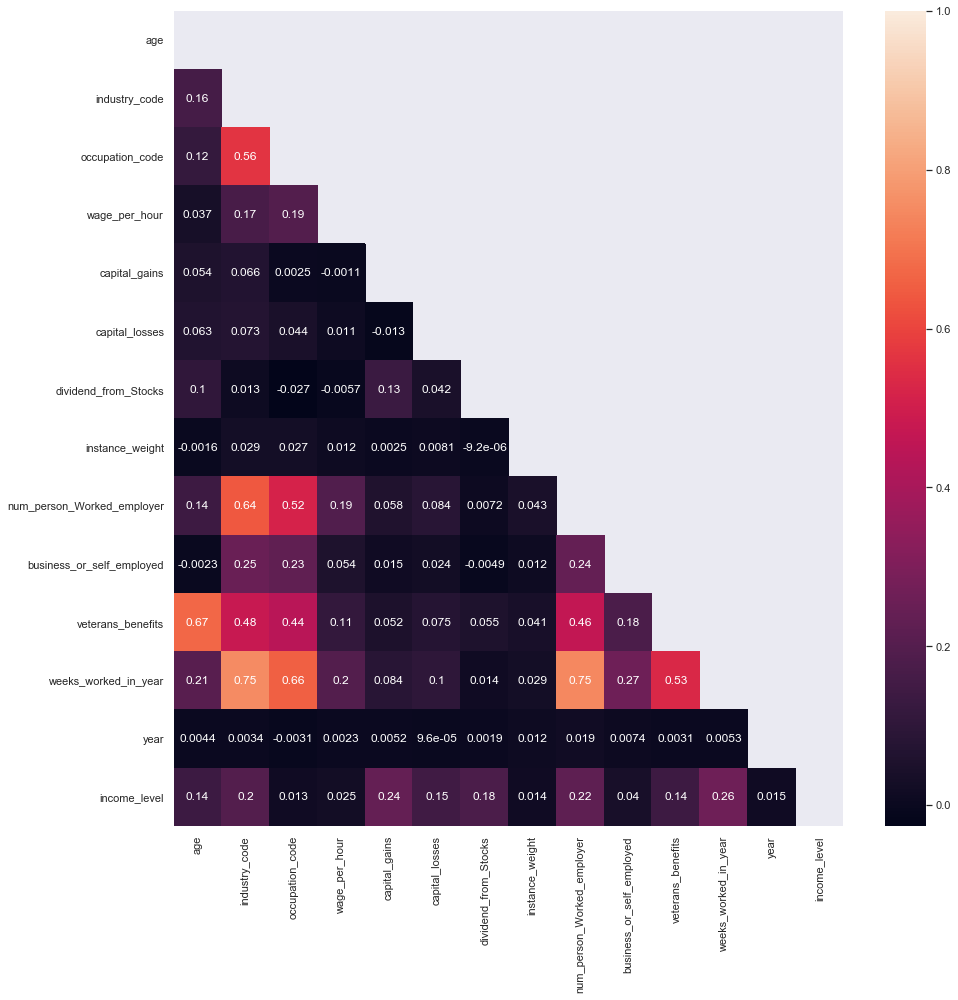

In [24]:
corr = train_data[numeric_cols].corr()
# Generate a mask for the upper triangle
matrix = np.triu(corr)
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(corr, annot=True, mask=matrix)
plt.show()

We consider the Correlation coefficients  between 0.7 and 1.0 to indicate high correlation. Hence, the **weeks_worked_in_year** variable is highly correlated with **industry_code** and **num_person_worked_employer** are  highly correlated. Its recommended to remove them to prevent redundancy

## Data Cleaning and Preparation

**Check percentage of missing values per variable**

In [25]:
train_data.isnull().sum()/len(train_data)*100

age                                  0.000000
class_of_worker                      0.000000
industry_code                        0.000000
occupation_code                      0.000000
education                            0.000000
wage_per_hour                        0.000000
enrolled_in_edu_inst_lastwk          0.000000
marital_status                       0.000000
major_industry_code                  0.000000
major_occupation_code                0.000000
race                                 0.000000
hispanic_origin                      0.438045
sex                                  0.000000
member_of_labor_union                0.000000
reason_for_unemployment              0.000000
full_parttime_employment_stat        0.000000
capital_gains                        0.000000
capital_losses                       0.000000
dividend_from_Stocks                 0.000000
tax_filer_status                     0.000000
region_of_previous_residence         0.000000
state_of_previous_residence       

### Visualize missing values

Visualizing missing value using bar graph


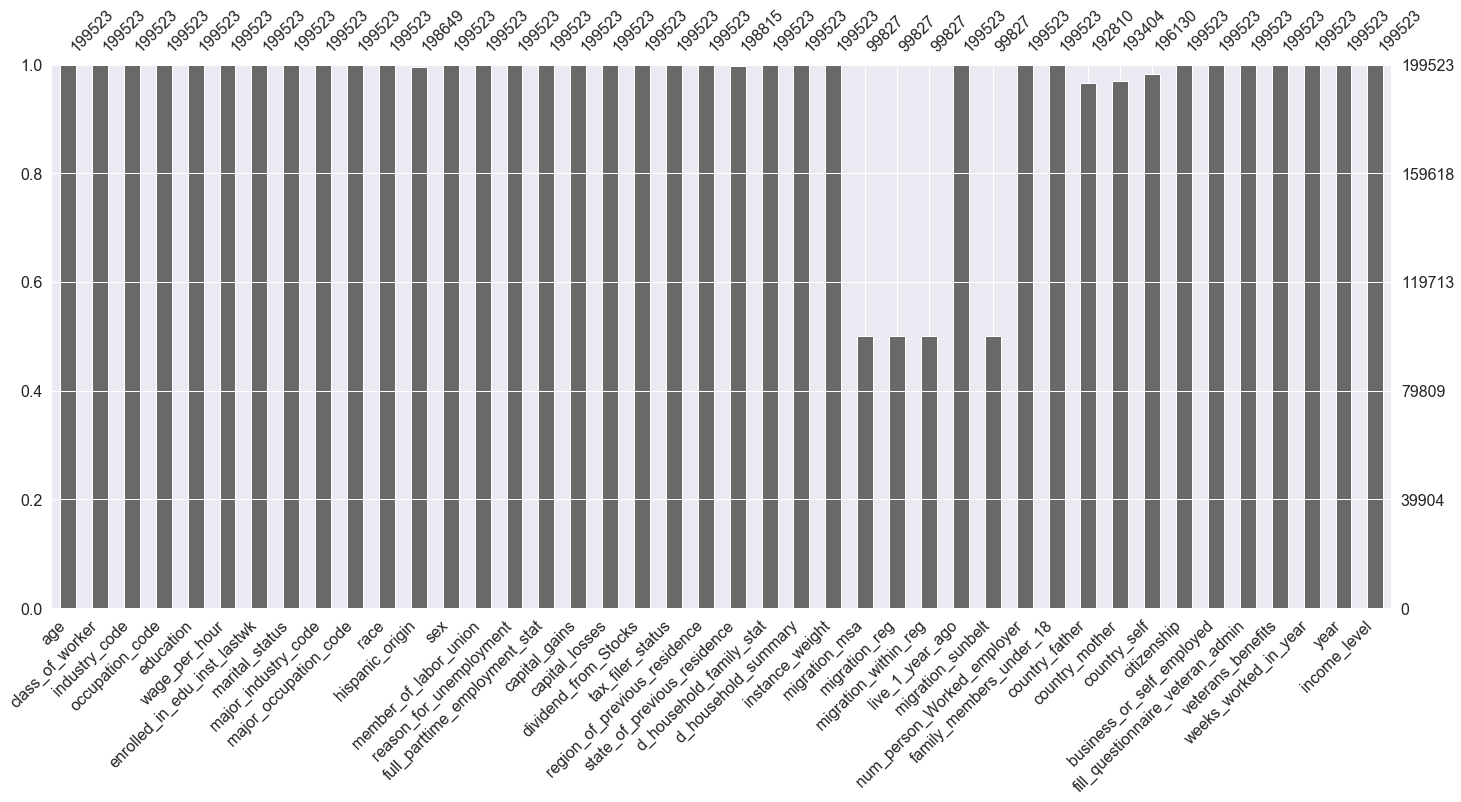

In [26]:
print('Visualizing missing value using bar graph')
mi.bar(train_data)
plt.show()

Visualizing missing value using Matrix


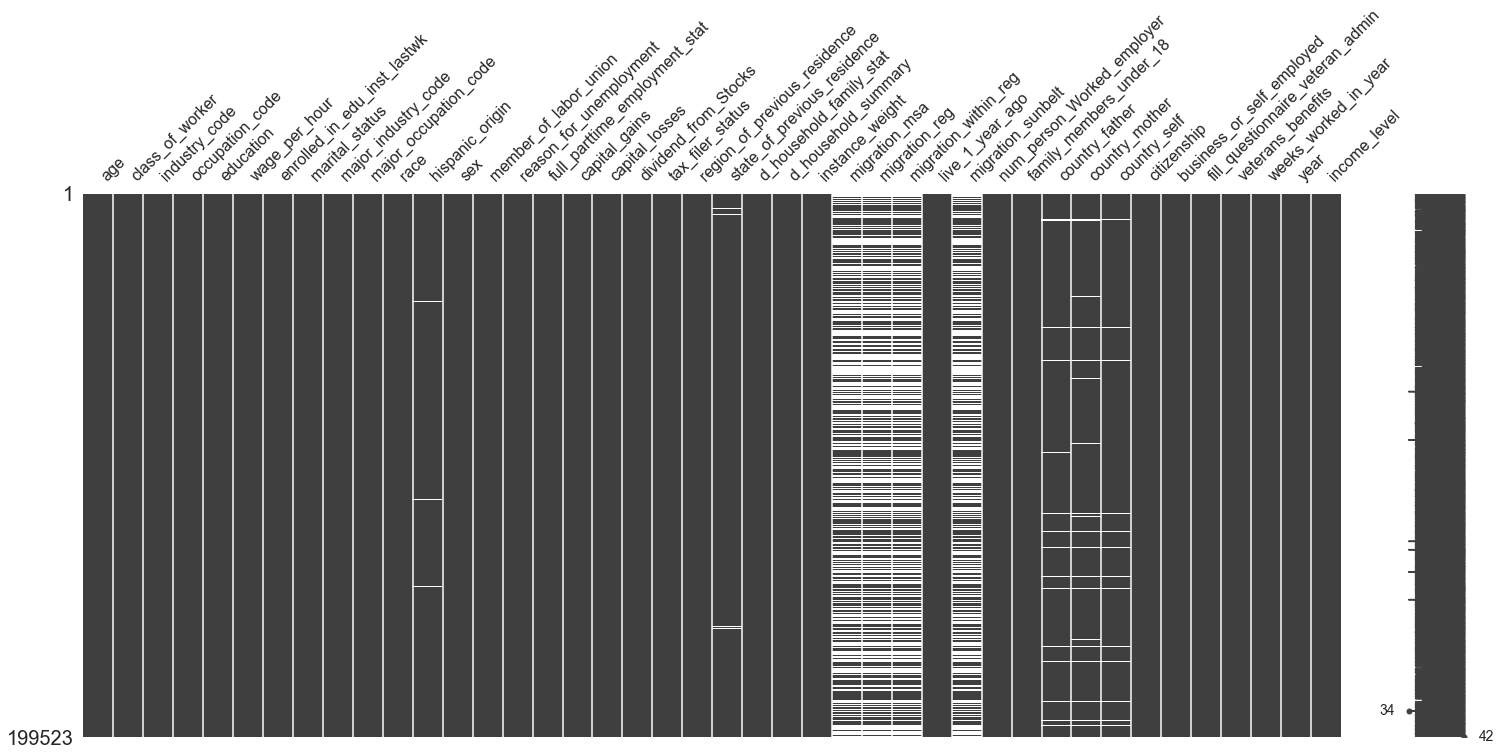

In [27]:
print('Visualizing missing value using Matrix')
mi.matrix(train_data)
plt.show()

**From the above bar graph and matrix:** We can see a lot of missing values in 'migration_msa', 'migration_reg',  'migration_within_reg', 'migration_sunbelt'. Some few missing values in 'hispanic_origin', 'state_of_previous_residence', country of fathers, 'country of mother' and 'country of self'

### check percentage of missing values per variable

In [28]:
test_data.isnull().sum()/len(test_data)*100

age                                  0.000000
class_of_worker                      0.000000
industry_code                        0.000000
occupation_code                      0.000000
education                            0.000000
wage_per_hour                        0.000000
enrolled_in_edu_inst_lastwk          0.000000
marital_status                       0.000000
major_industry_code                  0.000000
major_occupation_code                0.000000
race                                 0.000000
hispanic_origin                      0.405966
sex                                  0.000000
member_of_labor_union                0.000000
reason_for_unemployment              0.000000
full_parttime_employment_stat        0.000000
capital_gains                        0.000000
capital_losses                       0.000000
dividend_from_Stocks                 0.000000
tax_filer_status                     0.000000
region_of_previous_residence         0.000000
state_of_previous_residence       

### Visualize missing values

Visualizing missing value using bar graph


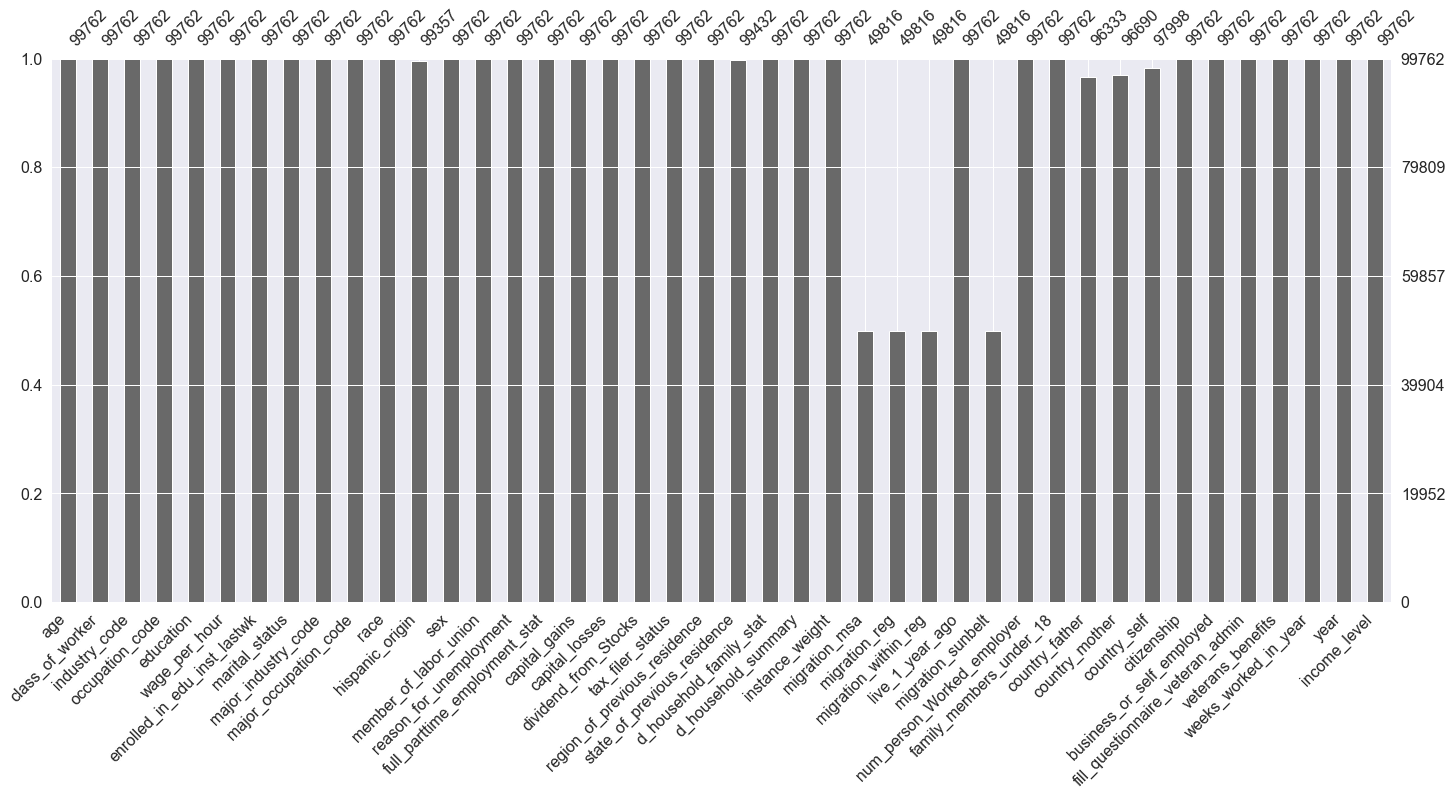

In [29]:
print('Visualizing missing value using bar graph')
mi.bar(test_data)
plt.show()

Visualizing missing value using Matrix


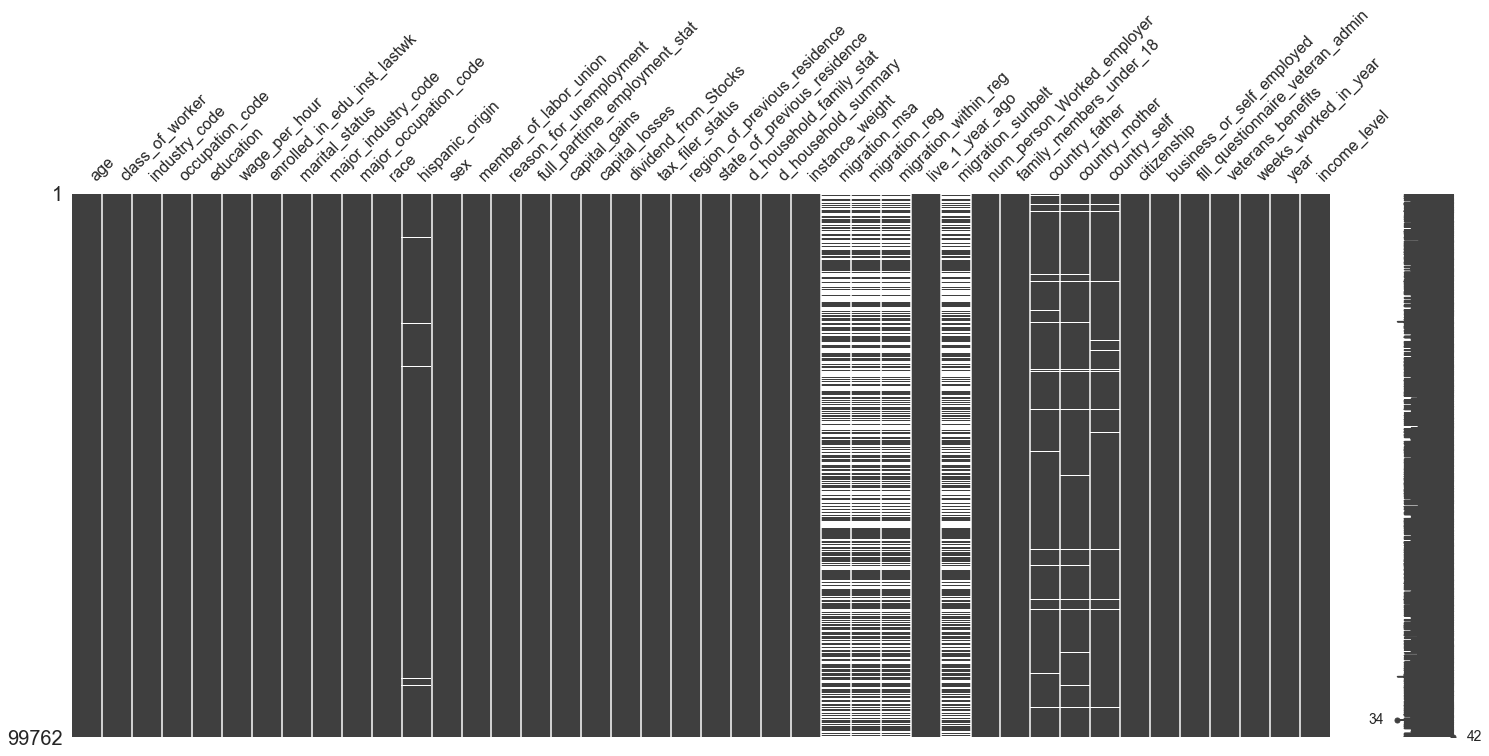

In [30]:
print('Visualizing missing value using Matrix')
mi.matrix(test_data)
plt.show()

### Transform the test and train datasets

In [31]:
def transform(data):
    '''
    Function to transform and clean train data
    '''
    if 'instance_weight' in data.columns:
        data.drop(columns=['instance_weight'], inplace=True)

    #Remove redundant variables and also variables having ~50% missing values 
    data.drop(columns=['weeks_worked_in_year', 'migration_msa', 'migration_reg',  'migration_within_reg',
                       'migration_sunbelt'], inplace=True)
    
    #Remove white space at the beginning of each value within the Non-numeric values
    object_cols = list(train_data.select_dtypes(include=['object']))
    
    for i in object_cols:
        data[i] = data[i].str.strip()
    
    #Fill missing values with a new value ‘Unavailable’
    data.fillna('Unavailable', inplace=True)
    
    #Transform Categorical variables using one-hot encoding
    encoded = pd.get_dummies(data)
    
    #Replace any blank space in the column name with an underscore
    encoded.columns = encoded.columns.str.replace(" ", "_")
    
    #remove [, ] or < from your column names
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    encoded.columns = [regex.sub("_", col) 
                       if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in encoded.columns.values]

    return encoded

In [32]:
#Transform and clean the data
transformed_train_data = transform(train_data)
transformed_test_data = transform(test_data)

#Ensure the test data is encoded in the same manner as the training data with the align command:
final_train, final_test = transformed_train_data.align(transformed_test_data, join='left', fill_value= 0 ,axis=1)

#Final dataset
X_train, y_train = final_train.drop(columns=['income_level']), final_train['income_level']
X_test, y_test = final_test.drop(columns=['income_level']), final_test['income_level']

# describes info about train and test set
print('Train dataset  %s' % Counter(y_train))
print('Test dataset %s' % Counter(y_test))

Train dataset  Counter({0: 187141, 1: 12382})
Test dataset Counter({0: 93576, 1: 6186})


#### Training a model using Logistic Regression on the original imbalanced dataset:

In [33]:
lr = LogisticRegression() 
  
# train the model on using the original imbalanced dataset
lr.fit(X_train, y_train)#.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions).upper()) 

              PRECISION    RECALL  F1-SCORE   SUPPORT

           0       0.95      1.00      0.97     93576
           1       0.73      0.17      0.27      6186

    ACCURACY                           0.94     99762
   MACRO AVG       0.84      0.58      0.62     99762
WEIGHTED AVG       0.93      0.94      0.93     99762



**The model accuracy comes out to be 94% but something strange is noticed**
- The recall of the minority class in very less. It proves that the model is more biased towards majority class. So, it is not the best model.

## Balancing the dataset:
To solve the imbalanced dataset problem, I use **SMOTE Algorithm** as the oversampling method and **Near Miss Algorithm** as the under-sampling technique

- **Synthetic Minority Oversampling Technique (SMOTE)** attempts to balance the data set by creating synthetic instances.
Data oversampling is a technique applied to generate data in such a way that it resembles the underlying distribution of the real data. 
![over sampling](oversample.png)

- **Near Miss Algorithm** is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. 
![under sampling](undersample.png)

### SMOTE - oversampling

In [34]:
print('Original dataset %s' % Counter(y_train))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
print('Oversampled dataset %s' % Counter(y_train_res))

Original dataset Counter({0: 187141, 1: 12382})
Oversampled dataset Counter({0: 187141, 1: 187141})


**Train the model using the oversampled (balanced) dataset**

In [35]:
lr1 = LogisticRegression() 

#Train the model using the Oversampled (balanced) dataset
lr1.fit(X_train_res, y_train_res.ravel()) 

predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions).upper()) 

              PRECISION    RECALL  F1-SCORE   SUPPORT

           0       0.98      0.82      0.89     93576
           1       0.22      0.78      0.34      6186

    ACCURACY                           0.82     99762
   MACRO AVG       0.60      0.80      0.62     99762
WEIGHTED AVG       0.94      0.82      0.86     99762



Oversampling reduces the model accuracy to 82% and improves the recall value of minority class 82%. This is a better model compared to the previous one.

### Near Miss - undersampling

In [36]:
print('Original dataset  %s' % Counter(y_train))

nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel()) 
print('Undersampled dataset  %s' % Counter(y_train_miss))

Original dataset  Counter({0: 187141, 1: 12382})
Undersampled dataset  Counter({0: 12382, 1: 12382})


**Train the model using the undersampled (balanced) dataset**

In [37]:
lr2 = LogisticRegression() 

#Train the model using the undersampled (balanced) dataset
lr2.fit(X_train_miss, y_train_miss.ravel()) 

predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions).upper()) 

              PRECISION    RECALL  F1-SCORE   SUPPORT

           0       0.99      0.52      0.68     93576
           1       0.11      0.93      0.20      6186

    ACCURACY                           0.55     99762
   MACRO AVG       0.55      0.72      0.44     99762
WEIGHTED AVG       0.94      0.55      0.65     99762



This model is better than the first model because it classifies better and also the recall value of minority class is 93 %. But due to undersampling, the recall of majority class decreased to 52%.

**So in this case, SMOTE is giving a great accuracy and recall, We can go ahead and use the SMOTE Technique! to balance the dataset**